In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *
import utils.BayesSpace
reload(utils.BayesSpace)
from utils.BayesSpace import Xenium_to_BayesSpace

In [2]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts.head()

# drop cells without ids
df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

# drop blanks and controls
df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

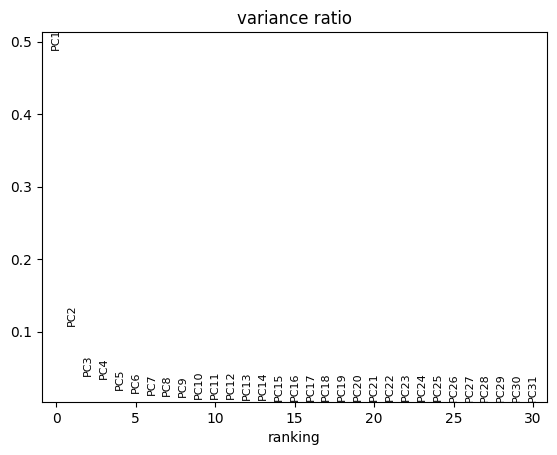

        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  0.925284     1.634874          0.355853
ACTA2              True  1.513941     2.441923          1.238844
ACTG2              True  0.766328     1.423526          0.180599
ADAM9             False  0.918933     0.683637         -1.281931
ADGRE5            False  0.252060     0.645113         -0.640158
...                 ...       ...          ...               ...
VWF                True  0.714762     2.509985          1.952661
WARS              False  0.596490     0.587796         -0.922031
ZEB1              False  0.564916     0.835983         -0.509801
ZEB2               True  0.917883     1.306149         -0.210127
ZNF562            False  1.030601     0.844585         -1.004820

[280 rows x 4 columns]
        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  0.925284     1.634874          0.355853
ACTA2              True  1.513941     2.441923          1.238844
A

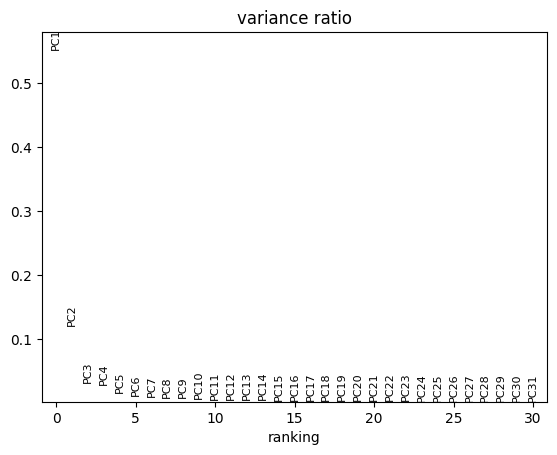

        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  1.895555     2.518792          1.226907
ACTA2              True  2.650975     3.323530          1.228076
ACTG2              True  1.663738     2.295395          0.184020
ADAM9             False  1.886602     1.399177         -1.152849
ADGRE5             True  0.725112     1.116034         -0.397694
...                 ...       ...          ...               ...
VWF                True  1.584579     3.015977          1.348975
WARS              False  1.393858     1.216467         -0.704604
ZEB1               True  1.340439     1.370176         -0.430894
ZEB2               True  1.885120     1.983381          0.088883
ZNF562            False  2.040834     1.797232         -0.864918

[280 rows x 4 columns]
        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  1.895555     2.518792          1.226907
ACTA2              True  2.650975     3.323530          1.228076
A

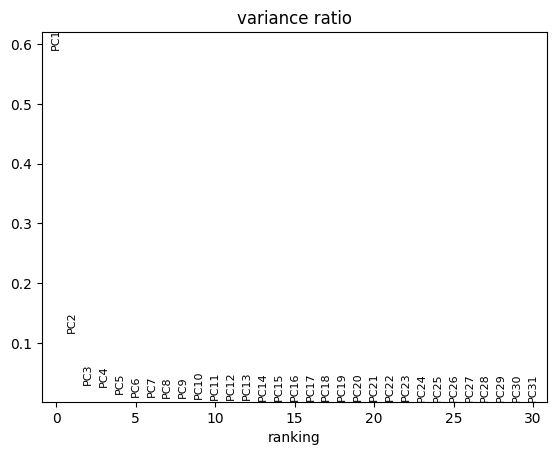

        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  2.591796     3.170950          0.716716
ACTA2              True  3.393156     3.793462          0.910998
ACTG2              True  2.336573     2.832351          0.633818
ADAM9             False  2.582045     1.994970         -1.899376
ADGRE5            False  1.201762     1.507325         -0.760004
...                 ...       ...          ...               ...
VWF                True  2.247942     3.256168          1.097181
WARS              False  2.030592     1.730193         -1.111963
ZEB1               True  1.968608     1.808156         -0.447642
ZEB2              False  2.580430     2.469615         -0.843476
ZNF562            False  2.748993     2.501476         -0.772600

[280 rows x 4 columns]
        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  2.591796     3.170950          0.716716
ACTA2              True  3.393156     3.793462          0.910998
A

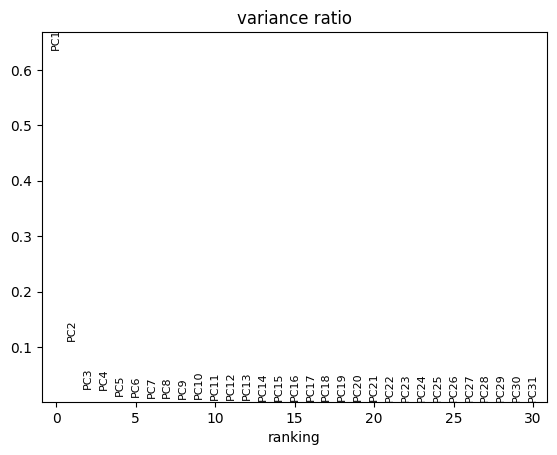

        highly_variable     means  dispersions  dispersions_norm
ABCC11             True  3.118124     3.661794          1.012870
ACTA2              True  3.937581     4.229662          0.938768
ACTG2              True  2.853223     3.241534          0.479590
ADAM9             False  3.108048     2.476190         -2.027012
ADGRE5            False  1.622870     1.866661         -0.708501
...                 ...       ...          ...               ...
VWF                True  2.760583     3.468477          0.749162
WARS              False  2.531667     2.137670         -1.249550
ZEB1               True  2.465869     2.188269         -0.447899
ZEB2              False  3.106379     2.869143         -1.019483
ZNF562            False  3.280128     3.029708         -0.607794

[280 rows x 4 columns]
         highly_variable     means  dispersions  dispersions_norm
ABCC11              True  3.118124     3.661794          1.012870
ACTA2               True  3.937581     4.229662          0.93876

In [3]:
for spot_size in [25, 50, 75, 100]:

    clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
    clustering.set_spot_size(spot_size)
    clustering.create_spot_data(third_dim=False, save_data=True)

    clustering.normalize_counts(clustering.xenium_spot_data)
    clustering.filter_only_high_variable_genes(clustering.xenium_spot_data)
    # generate the neigborhood graph based on pca
    sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack')
    sc.pl.pca_variance_ratio(clustering.xenium_spot_data)
    print(clustering.xenium_spot_data.var)
    clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
    print(clustering.xenium_spot_data.var)

    Xenium_to_BayesSpace(clustering.xenium_spot_data, spot_size)